<a href="https://colab.research.google.com/github/kentucky84/cnn_test/blob/main/MNIST_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Library Import


In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
cd '/gdrive/MyDrive/Colab Notebooks/cnn_test'

/gdrive/MyDrive/Colab Notebooks/cnn_test


In [3]:
!pwd

/gdrive/MyDrive/Colab Notebooks/cnn_test


In [4]:
import sklearn
from sklearn.model_selection import train_test_split  

In [5]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

In [12]:
if torch.cuda.is_available() == True:
  torch.device("cuda")
else: 
  torch.device("cpu")

In [13]:
data_mnist = datasets.MNIST(download = True,
                            train = True, 
                            root = 'mnist',
                            transform=transforms.ToTensor())

data_mnist_test = datasets.MNIST(download = True,
                            train = False, 
                            root = 'mnist',
                            transform=transforms.ToTensor())

In [14]:
print(len(data_mnist))
print(len(data_mnist_test))

60000
10000


In [15]:
print(type(data_mnist))

<class 'torchvision.datasets.mnist.MNIST'>


In [16]:
data_target = data_mnist.targets

In [17]:
data_mnist[2][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

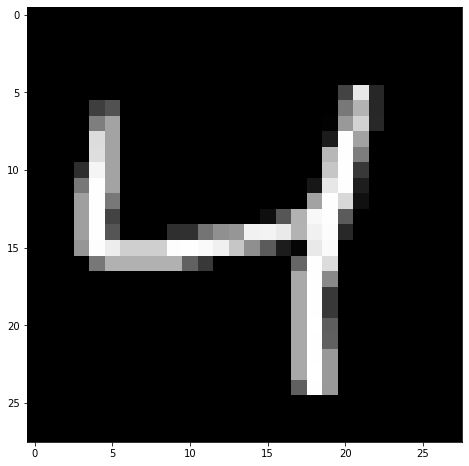

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.imshow(data_mnist[2][0][0], cmap='gray')


In [19]:
train_data_loader = torch.utils.data.DataLoader(dataset = data_mnist,
                                             batch_size = 32,
                                             shuffle = True,
                                             )

test_data_loader = torch.utils.data.DataLoader(dataset = data_mnist_test,
                                             batch_size = 32,
                                             shuffle = False)



In [20]:
next(iter(train_data_loader))[0][1][0].shape

torch.Size([28, 28])

In [21]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        #  Output Feature Map 사이즈 계산 공식 : (input size - filter + 2*p) / s + 1
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [22]:
model = CNN()
model.cuda()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
loss_function = torch.nn.CrossEntropyLoss()


In [32]:
model.train()
num_epochs = 10


for epoch in range(num_epochs):
  for index, (data, target) in enumerate(train_data_loader):
    optimizer.zero_grad()
    output = model(data.to("cuda"))
    print(target.to("cuda"))
    loss = loss_function(output, target.to("cuda"))
    loss.backward()
    optimizer.step()

    print(f'loss of epoch{epoch} - {index} : {loss}')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        6, 6, 5, 3, 7, 2, 7, 4], device='cuda:0')
loss of epoch9 - 208 : 0.016437744721770287
tensor([0, 8, 5, 1, 3, 4, 7, 8, 4, 1, 4, 0, 4, 1, 2, 1, 6, 0, 3, 1, 0, 3, 3, 1,
        2, 1, 6, 5, 6, 7, 0, 7], device='cuda:0')
loss of epoch9 - 209 : 0.04561271518468857
tensor([2, 3, 1, 4, 8, 2, 5, 9, 8, 9, 2, 7, 8, 7, 0, 9, 8, 8, 9, 3, 8, 8, 8, 6,
        1, 8, 3, 5, 9, 2, 9, 0], device='cuda:0')
loss of epoch9 - 210 : 0.17479297518730164
tensor([2, 9, 9, 4, 4, 4, 1, 3, 0, 7, 4, 0, 1, 7, 3, 7, 1, 3, 6, 7, 0, 3, 8, 6,
        1, 2, 1, 2, 1, 0, 6, 9], device='cuda:0')
loss of epoch9 - 211 : 0.035290736705064774
tensor([9, 3, 7, 4, 7, 4, 3, 3, 2, 4, 7, 9, 0, 8, 4, 9, 6, 6, 7, 4, 8, 6, 1, 6,
        9, 9, 9, 5, 8, 7, 1, 5], device='cuda:0')
loss of epoch9 - 212 : 0.12284586578607559
tensor([2, 0, 8, 7, 2, 9, 4, 0, 2, 2, 1, 9, 0, 2, 6, 1, 1, 0, 9, 9, 8, 3, 8, 9,
        2, 4, 2, 5, 7, 0, 6, 1], device='cuda:0')
loss of epoch9 - 213 : 0.03944044187664986
tens

In [31]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_data_loader:
    output = model(data.to('cuda'))
    test_loss += loss_function(output, target.to('cuda')).item()
    print(output)
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_data_loader.dataset),
        100. * correct / len(test_data_loader.dataset)))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [ 2.0487, -2.1250,  6.9154,  4.5662, -6.8526, -1.8599, -1.3243,  0.4910,
          4.0104, -3.0844],
        [-3.6195,  7.9669, -2.3496, -1.6394,  0.4565, -1.0152,  1.3829, -3.4856,
          2.0950, -2.1948],
        [-4.2172, -3.2394, -1.5041, 12.4527, -4.0682,  5.7839, -4.9553, -0.8951,
          2.5415,  1.5822],
        [-3.9904, -0.6121, -2.3418, -0.3915,  2.2114, -1.0039, -4.6826, -0.5162,
          2.5026,  7.2439],
        [-3.1519, -2.7383, -1.0621, -1.0323,  2.1350,  0.2959, -2.7637, -1.8761,
          3.8414,  6.3770],
        [-1.0912, -0.4591,  1.4357, -0.2739, -4.2560,  1.0870,  1.5552, -5.9966,
          9.7307, -2.4645],
        [-2.9324, -1.7208, -1.5412,  1.8917, -3.4571,  8.1356,  2.6879, -3.4172,
          1.4973, -1.2045],
        [-3.7405, -3.7783, -1.3199, 11.9145, -4.0577,  4.6223, -5.6065,  1.5505,
          1.3400,  2.5140],
        [-2.6086, -2.6058,  0.6959,  1.8000, -2.3353, -0.7165, -4.8837, 11.9498,
         -0

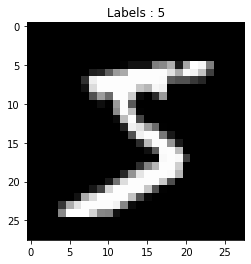

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(t_x[0], cmap = 'gray', )
plt.title(f'Labels : {t_y[0]}')
plt.show()

In [ ]:
x_train[0].shape


torch.Size([28, 28])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(t_x, t_y, train_size = 0.8, random_state = 111, shuffle = True)

In [ ]:
len(x_train)

48000

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader

In [ ]:
batch_size = 16
train_loader = DataLoader(dataset = (y_train, x_train),
                          batch_size = batch_size,
                          shuffle = True)


In [ ]:
test_loader = DataLoader(dataset = (y_test, x_test),
                         batch_size = batch_size,
                         shuffle = True)

In [ ]:
first_batch